<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/6_attitude_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 6: Attitude Space

Building an **Attitude Space** parallel to the Demographic Space (Phase 5/5.1).

We extract steering vectors for **~96 attitude positions** across **34 social-issue variables**
from the GSS, then apply within-category centering and PCA to discover interpretable axes of
attitudinal variation.

**Key design decisions:**
- All response options kept (not binary-collapsed). 7-point Likert scales collapsed to 3 meaningful groups.
- Shared baseline: all positions use the same "person" baseline. X- mean computed ONCE per layer.
- Same 5 neutral Q&A pairs as demographic extraction (Phase 1).
- Categories = GSS variable names (34 total). Within-category centering removes shared "attitude-ness".

**Pipeline:**
1. Define 34 attitude variables with ~96 positions (response options)
2. Generate contrastive prompts (attitude persona vs generic baseline)
3. Extract vectors from Llama-3 layers 5-20 (shared baseline optimization)
4. PCA on centered attitude vectors → Attitude Space
5. Cross-space comparison with Demographic Space

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import json
import time

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.cm import get_cmap

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = '/content/drive/MyDrive/belief_and_llms_v0'
except ImportError:
    BASE_DIR = '.'

VECTOR_DIR = os.path.join(BASE_DIR, 'vectors')
DATA_DIR = os.path.join(BASE_DIR, 'data')
os.makedirs(VECTOR_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'

# Install bitsandbytes if not already installed or if version is too old
!pip install -U bitsandbytes>=0.46.1

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto',
    torch_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

LAYERS_TO_EXTRACT = list(range(5, 21))

print(f'Model loaded: {model_name}')
print(f'Layers to extract: {LAYERS_TO_EXTRACT}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Model loaded: meta-llama/Meta-Llama-3-8B-Instruct
Layers to extract: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [3]:
# Each category maps to a list of natural-language persona labels.
# Format: {GSS_variable_name: [position_label_1, position_label_2, ...]}
# Labels are used directly in prompts: "You are a (an) {label} living in the United States."

attitude_maps = {
    # ── 4 Existing Social Issues (8 positions) ──────────────────────────────
    'Abortion': [
        'pro-choice person',
        'pro-life person',
    ],
    'GunControl': [
        'person who supports stricter gun control',
        'person who supports gun rights',
    ],
    'SameSexMarriage': [
        'person who supports same-sex marriage',
        'person who opposes same-sex marriage',
    ],
    'DeathPenalty': [
        'person who favors the death penalty',
        'person who opposes the death penalty',
    ],

    # ── 8 Government Spending Variables (24 positions) ───────────────────────
    'natspac': [
        'person who thinks we spend too little on space exploration',
        'person who thinks we spend about the right amount on space exploration',
        'person who thinks we spend too much on space exploration',
    ],
    'natenvir': [
        'person who thinks we spend too little on the environment',
        'person who thinks we spend about the right amount on the environment',
        'person who thinks we spend too much on the environment',
    ],
    'natcrime': [
        'person who thinks we spend too little on crime prevention',
        'person who thinks we spend about the right amount on crime prevention',
        'person who thinks we spend too much on crime prevention',
    ],
    'natdrug': [
        'person who thinks we spend too little on drug rehabilitation',
        'person who thinks we spend about the right amount on drug rehabilitation',
        'person who thinks we spend too much on drug rehabilitation',
    ],
    'nateduc': [
        'person who thinks we spend too little on education',
        'person who thinks we spend about the right amount on education',
        'person who thinks we spend too much on education',
    ],
    'natrace': [
        'person who thinks we spend too little on improving the conditions of Black Americans',
        'person who thinks we spend about the right amount on improving the conditions of Black Americans',
        'person who thinks we spend too much on improving the conditions of Black Americans',
    ],
    'natarms': [
        'person who thinks we spend too little on the military and defense',
        'person who thinks we spend about the right amount on the military and defense',
        'person who thinks we spend too much on the military and defense',
    ],
    'natfare': [
        'person who thinks we spend too little on welfare',
        'person who thinks we spend about the right amount on welfare',
        'person who thinks we spend too much on welfare',
    ],

    # ── 22 Other Attitude Variables (64 positions) ──────────────────────────
    'eqwlth': [
        'person who believes government should reduce income differences',
        'person who is neutral on whether government should reduce income differences',
        'person who believes government should not concern itself with income differences',
    ],
    'courts': [
        'person who thinks courts are too harsh on criminals',
        'person who thinks courts are about right on criminals',
        'person who thinks courts are not harsh enough on criminals',
    ],
    'librac': [
        'person who believes a racist should be allowed to speak publicly',
        'person who believes a racist should not be allowed to speak publicly',
    ],
    'libath': [
        'person who believes an atheist should be allowed to speak publicly',
        'person who believes an atheist should not be allowed to speak publicly',
    ],
    'grass': [
        'person who thinks marijuana should be legal',
        'person who thinks marijuana should not be legal',
    ],
    'bible': [
        'person who believes the Bible is the literal word of God',
        'person who believes the Bible is the inspired word of God but not literal',
        'person who believes the Bible is a book of fables',
    ],
    'world1': [
        'person who believes the world is fundamentally good',
        'person who believes the world is neither good nor evil',
        'person who believes the world is fundamentally evil',
    ],
    'world4': [
        'person who believes people are fundamentally good',
        'person who believes people are neither good nor evil',
        'person who believes people are fundamentally evil',
    ],
    'racopen': [
        'person who believes a homeowner should have the right to refuse to sell to someone of a different race',
        'person who believes a homeowner should not be allowed to discriminate in selling their home',
    ],
    'affrmact': [
        'person who strongly favors affirmative action',
        'person who favors affirmative action',
        'person who opposes affirmative action',
        'person who strongly opposes affirmative action',
    ],
    'trust': [
        'person who believes most people can be trusted',
        'person who believes whether people can be trusted depends',
        "person who believes you can't be too careful with people",
    ],
    'fair': [
        'person who believes most people try to be fair',
        'person who believes whether people are fair depends',
        'person who believes most people try to take advantage',
    ],
    'richwork': [
        'person who would continue working if rich',
        'person who would stop working if rich',
    ],
    'premarsx': [
        'person who thinks premarital sex is not wrong at all',
        'person who thinks premarital sex is sometimes wrong',
        'person who thinks premarital sex is almost always wrong',
        'person who thinks premarital sex is always wrong',
    ],
    'xmarsex': [
        'person who thinks extramarital sex is not wrong at all',
        'person who thinks extramarital sex is sometimes wrong',
        'person who thinks extramarital sex is almost always wrong',
        'person who thinks extramarital sex is always wrong',
    ],
    'letdie1': [
        'person who believes a terminally ill patient should have the right to die',
        'person who believes a terminally ill patient should not have the right to die',
    ],
    'spanking': [
        'person who strongly agrees that spanking is appropriate',
        'person who agrees that spanking is appropriate',
        'person who disagrees that spanking is appropriate',
        'person who strongly disagrees that spanking is appropriate',
    ],
    'helppoor': [
        'person who believes government should help the poor',
        'person who has mixed views on government help for the poor',
        'person who believes people should help themselves',
    ],
    'helpsick': [
        'person who believes government should help pay for medical care',
        'person who has mixed views on government help for medical care',
        'person who believes people should pay for their own medical care',
    ],
    'workwhts': [
        'person who perceives White people as generally hard-working',
        'person who perceives White people as average in work ethic',
        'person who perceives White people as generally lazy',
    ],
    'workblks': [
        'person who perceives Black people as generally hard-working',
        'person who perceives Black people as average in work ethic',
        'person who perceives Black people as generally lazy',
    ],
    'workhsps': [
        'person who perceives Hispanic people as generally hard-working',
        'person who perceives Hispanic people as average in work ethic',
        'person who perceives Hispanic people as generally lazy',
    ],
}

# Summary
n_categories = len(attitude_maps)
n_positions = sum(len(positions) for positions in attitude_maps.values())
print(f'Attitude variables: {n_categories} categories, {n_positions} total positions')
print()
for cat, positions in attitude_maps.items():
    print(f'  {cat:20s}: {len(positions)} positions')

Attitude variables: 34 categories, 96 total positions

  Abortion            : 2 positions
  GunControl          : 2 positions
  SameSexMarriage     : 2 positions
  DeathPenalty        : 2 positions
  natspac             : 3 positions
  natenvir            : 3 positions
  natcrime            : 3 positions
  natdrug             : 3 positions
  nateduc             : 3 positions
  natrace             : 3 positions
  natarms             : 3 positions
  natfare             : 3 positions
  eqwlth              : 3 positions
  courts              : 3 positions
  librac              : 2 positions
  libath              : 2 positions
  grass               : 2 positions
  bible               : 3 positions
  world1              : 3 positions
  world4              : 3 positions
  racopen             : 2 positions
  affrmact            : 4 positions
  trust               : 3 positions
  fair                : 3 positions
  richwork            : 2 positions
  premarsx            : 4 positions
  xmarsex

In [4]:
# Same 5 neutral Q&A pairs used in demographic extraction (Phase 1)
QA_PAIRS = [
    ('Describe your morning routine.',
     'I woke up, brushed my teeth, and had a cup of coffee before checking the news.'),
    ('What are you having for lunch?',
     "I'm planning to have a sandwich and a salad at a local cafe."),
    ('How is the weather today?',
     'It is partly cloudy and a bit brisk, but the sun is peeking through.'),
    ('What are your plans for the weekend?',
     'I plan to relax at home, catch up on some reading, and maybe go for a walk.'),
    ('Describe your commute.',
     'I traveled to the city center and listened to a podcast on the way.'),
]

BASELINE_LABEL = 'person'


def make_prompt(persona, question, answer):
    return f'[INST] You are a (an) {persona} living in the United States. {question} [/INST] {answer}'


# Build extraction datasets: {label: [[X+, X-], ...]}
extraction_datasets = {}

for category, positions in attitude_maps.items():
    for position in positions:
        label = f'{category}_{position}'
        pairs = []
        for q, a in QA_PAIRS:
            pos_prompt = make_prompt(position, q, a)
            neg_prompt = make_prompt(BASELINE_LABEL, q, a)
            pairs.append([pos_prompt, neg_prompt])
        extraction_datasets[label] = pairs

# Baseline prompts (shared across all positions)
baseline_prompts = [make_prompt(BASELINE_LABEL, q, a) for q, a in QA_PAIRS]

print(f'Total attitude positions: {len(extraction_datasets)}')
print(f'Prompt pairs per position: {len(QA_PAIRS)}')
print(f'Baseline prompts: {len(baseline_prompts)}')

# Save extraction datasets
save_path = os.path.join(DATA_DIR, 'gss_attitude_extraction_datasets.json')
with open(save_path, 'w') as f:
    json.dump(extraction_datasets, f, indent=4)
print(f'Saved to {save_path}')

# Print a sample
sample_label = list(extraction_datasets.keys())[0]
print(f'\nSample ({sample_label}):')
print(f'  X+: {extraction_datasets[sample_label][0][0][:100]}...')
print(f'  X-: {extraction_datasets[sample_label][0][1][:100]}...')

Total attitude positions: 96
Prompt pairs per position: 5
Baseline prompts: 5
Saved to /content/drive/MyDrive/belief_and_llms_v0/data/gss_attitude_extraction_datasets.json

Sample (Abortion_pro-choice person):
  X+: [INST] You are a (an) pro-choice person living in the United States. Describe your morning routine. ...
  X-: [INST] You are a (an) person living in the United States. Describe your morning routine. [/INST] I w...


In [5]:
def get_layer_activations(model, tokenizer, inputs_text, layer_idx):
    """Extract hidden state at last token position from a specific layer."""
    inputs = tokenizer(inputs_text, return_tensors='pt').to(model.device)
    captured_hidden = None

    def hook_fn(module, input, output):
        nonlocal captured_hidden
        if isinstance(output, tuple):
            h_states = output[0]
        else:
            h_states = output
        if h_states.dim() == 3:
            captured_hidden = h_states[0, -1, :].detach().cpu()
        elif h_states.dim() == 2:
            captured_hidden = h_states[-1, :].detach().cpu()
        else:
            raise ValueError(f'Unexpected tensor shape: {h_states.shape}')

    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(**inputs)
    handle.remove()
    return captured_hidden


def compute_baseline_mean(model, tokenizer, baseline_prompts, layer_idx):
    """Compute mean activation for shared baseline prompts."""
    acts = []
    for text in baseline_prompts:
        act = get_layer_activations(model, tokenizer, text, layer_idx)
        acts.append(act)
    return torch.mean(torch.vstack(acts), dim=0)


def extract_attitude_vectors(model, tokenizer, extraction_datasets, layer_idx, baseline_mean):
    """
    Extract attitude vectors for a single layer using precomputed baseline mean.

    Returns: {label: {'vector': normalized_tensor, 'magnitude': float}}
    """
    attitude_vectors = {}

    for label, pairs in extraction_datasets.items():
        pos_texts = [p[0] for p in pairs]

        pos_acts = []
        for text in pos_texts:
            act = get_layer_activations(model, tokenizer, text, layer_idx)
            pos_acts.append(act)

        pos_mean = torch.mean(torch.vstack(pos_acts), dim=0)
        diff_vector = pos_mean - baseline_mean

        raw_magnitude = torch.norm(diff_vector).item()
        if raw_magnitude > 0:
            normalized_vector = diff_vector / torch.norm(diff_vector)
        else:
            normalized_vector = diff_vector

        attitude_vectors[label] = {
            'vector': normalized_vector,
            'magnitude': raw_magnitude,
        }

    return attitude_vectors

print('Extraction functions defined.')
print(f'  Shared baseline optimization: X- computed once per layer ({len(baseline_prompts)} prompts)')
print(f'  Per-position forward passes: {len(QA_PAIRS)} (X+ only)')
print(f'  Total forward passes per layer: {len(baseline_prompts)} + {len(extraction_datasets)} * {len(QA_PAIRS)} = {len(baseline_prompts) + len(extraction_datasets) * len(QA_PAIRS)}')

Extraction functions defined.
  Shared baseline optimization: X- computed once per layer (5 prompts)
  Per-position forward passes: 5 (X+ only)
  Total forward passes per layer: 5 + 96 * 5 = 485


In [6]:
print(f'Extracting attitude vectors across layers {LAYERS_TO_EXTRACT}')
print(f'Positions: {len(extraction_datasets)}, Prompts per position: {len(QA_PAIRS)}')
print(f'Baseline computed ONCE per layer ({len(baseline_prompts)} prompts)')
print()

total_start = time.time()

for layer_idx in LAYERS_TO_EXTRACT:
    layer_start = time.time()

    # Compute baseline mean once for this layer
    baseline_mean = compute_baseline_mean(model, tokenizer, baseline_prompts, layer_idx)

    # Extract all attitude vectors using shared baseline
    vectors = extract_attitude_vectors(
        model, tokenizer, extraction_datasets, layer_idx, baseline_mean
    )

    # Save
    save_path = os.path.join(VECTOR_DIR, f'gss_attitude_vectors_layer{layer_idx}.pt')
    torch.save(vectors, save_path)

    elapsed = time.time() - layer_start
    print(f'Layer {layer_idx:2d}: {len(vectors)} vectors saved ({elapsed:.1f}s)')

total_elapsed = time.time() - total_start
print(f'\nTotal extraction time: {total_elapsed / 60:.1f} minutes')

Extracting attitude vectors across layers [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Positions: 96, Prompts per position: 5
Baseline computed ONCE per layer (5 prompts)

Layer  5: 96 vectors saved (50.0s)
Layer  6: 96 vectors saved (48.5s)
Layer  7: 96 vectors saved (48.8s)
Layer  8: 96 vectors saved (48.2s)
Layer  9: 96 vectors saved (48.4s)
Layer 10: 96 vectors saved (48.1s)
Layer 11: 96 vectors saved (48.4s)
Layer 12: 96 vectors saved (48.5s)
Layer 13: 96 vectors saved (48.5s)
Layer 14: 96 vectors saved (48.6s)
Layer 15: 96 vectors saved (48.5s)
Layer 16: 96 vectors saved (48.5s)
Layer 17: 96 vectors saved (48.4s)
Layer 18: 96 vectors saved (48.3s)
Layer 19: 96 vectors saved (48.8s)
Layer 20: 96 vectors saved (48.7s)

Total extraction time: 13.0 minutes


In [7]:
REF_LAYER = 13

vectors = torch.load(
    os.path.join(VECTOR_DIR, f'gss_attitude_vectors_layer{REF_LAYER}.pt'),
    map_location='cpu',
    weights_only=True,
)

labels = sorted(vectors.keys())
categories = [lab.split('_')[0] for lab in labels]
unique_cats = sorted(set(categories))

magnitudes = np.array([vectors[lab]['magnitude'] for lab in labels])

print(f'Layer {REF_LAYER}: {len(vectors)} attitude vectors')
print(f'Vector dimension: {vectors[labels[0]]["vector"].shape[0]}')
print(f'Categories: {len(unique_cats)}')
print(f'\nMagnitude statistics:')
print(f'  Mean: {magnitudes.mean():.4f}')
print(f'  Std:  {magnitudes.std():.4f}')
print(f'  Min:  {magnitudes.min():.4f}  ({labels[np.argmin(magnitudes)]})')
print(f'  Max:  {magnitudes.max():.4f}  ({labels[np.argmax(magnitudes)]})')

# Compare with demographic vectors
try:
    demo_vectors = torch.load(
        os.path.join(VECTOR_DIR, f'gss_demographic_vectors_layer{REF_LAYER}.pt'),
        map_location='cpu',
        weights_only=True,
    )
    demo_mags = np.array([demo_vectors[lab]['magnitude'] for lab in sorted(demo_vectors.keys())])
    print(f'\nDemographic vector magnitudes (layer {REF_LAYER}):')
    print(f'  Mean: {demo_mags.mean():.4f}, Std: {demo_mags.std():.4f}')
    print(f'  Attitude vs Demographic ratio: {magnitudes.mean() / demo_mags.mean():.2f}x')
except FileNotFoundError:
    print('\n(Demographic vectors not found for comparison)')

# Top 10 highest-magnitude attitude positions
print(f'\nTop 10 highest-magnitude attitude positions:')
sorted_idx = np.argsort(magnitudes)[::-1]
for i in sorted_idx[:10]:
    print(f'  {magnitudes[i]:.4f}  {labels[i]}')

Layer 13: 96 attitude vectors
Vector dimension: 4096
Categories: 34

Magnitude statistics:
  Mean: 2.6855
  Std:  0.3825
  Min:  1.4883  (richwork_person who would continue working if rich)
  Max:  3.3867  (natrace_person who thinks we spend too much on improving the conditions of Black Americans)

Demographic vector magnitudes (layer 13):
  Mean: 1.4133, Std: 0.4497
  Attitude vs Demographic ratio: 1.90x

Top 10 highest-magnitude attitude positions:
  3.3867  natrace_person who thinks we spend too much on improving the conditions of Black Americans
  3.2852  libath_person who believes an atheist should not be allowed to speak publicly
  3.2598  courts_person who thinks courts are not harsh enough on criminals
  3.2207  natrace_person who thinks we spend too little on improving the conditions of Black Americans
  3.2070  librac_person who believes a racist should be allowed to speak publicly
  3.2051  natspac_person who thinks we spend too little on space exploration
  3.1777  racopen_

## Attitude Space PCA

Apply PCA to attitude vectors (with and without within-category centering) to discover
the dominant axes of attitudinal variation in Llama-3's hidden states.

In [8]:
# Build unnormalized matrix: direction * magnitude
X = np.array([
    (vectors[lab]['vector'] * vectors[lab]['magnitude']).numpy()
    for lab in labels
])

print(f'Attitude matrix: {X.shape}')

# Original PCA (before centering)
n_components = min(30, len(labels))
pca_orig = PCA(n_components=n_components)
X_pca_orig = pca_orig.fit_transform(X)

print(f'PC1 variance: {pca_orig.explained_variance_ratio_[0]:.2%}')
print(f'Top 5 PCs: {[f"{v:.2%}" for v in pca_orig.explained_variance_ratio_[:5]]}')
print(f'Cumulative (10 PCs): {sum(pca_orig.explained_variance_ratio_[:10]):.2%}')

# Color palette for 34 categories
n_cats = len(unique_cats)
tab20 = [get_cmap('tab20')(i / 20) for i in range(20)]
tab20b = [get_cmap('tab20b')(i / 20) for i in range(20)]
all_colors = tab20 + tab20b[:n_cats - 20] if n_cats > 20 else tab20[:n_cats]
cat_to_color = {cat: all_colors[i] for i, cat in enumerate(unique_cats)}

Attitude matrix: (96, 4096)
PC1 variance: 21.56%
Top 5 PCs: ['21.56%', '12.42%', '10.08%', '7.42%', '4.88%']
Cumulative (10 PCs): 71.69%


/tmp/ipython-input-3832416775.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = [get_cmap('tab20')(i / 20) for i in range(20)]
/tmp/ipython-input-3832416775.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20b = [get_cmap('tab20b')(i / 20) for i in range(20)]


Within-category centering verification:
  Abortion             (2 positions): mean_norm = 4.88e-04
  DeathPenalty         (2 positions): mean_norm = 5.98e-04
  GunControl           (2 positions): mean_norm = 5.46e-04
  SameSexMarriage      (2 positions): mean_norm = 5.46e-04
  affrmact             (4 positions): mean_norm = 5.98e-04
  bible                (3 positions): mean_norm = 4.88e-04
  courts               (3 positions): mean_norm = 5.98e-04
  eqwlth               (3 positions): mean_norm = 4.88e-04
  fair                 (3 positions): mean_norm = 4.88e-04
  grass                (2 positions): mean_norm = 5.98e-04
  helppoor             (3 positions): mean_norm = 5.46e-04
  helpsick             (3 positions): mean_norm = 4.88e-04
  letdie1              (2 positions): mean_norm = 6.46e-04
  libath               (2 positions): mean_norm = 6.46e-04
  librac               (2 positions): mean_norm = 6.90e-04
  natarms              (3 positions): mean_norm = 5.98e-04
  natcrime      

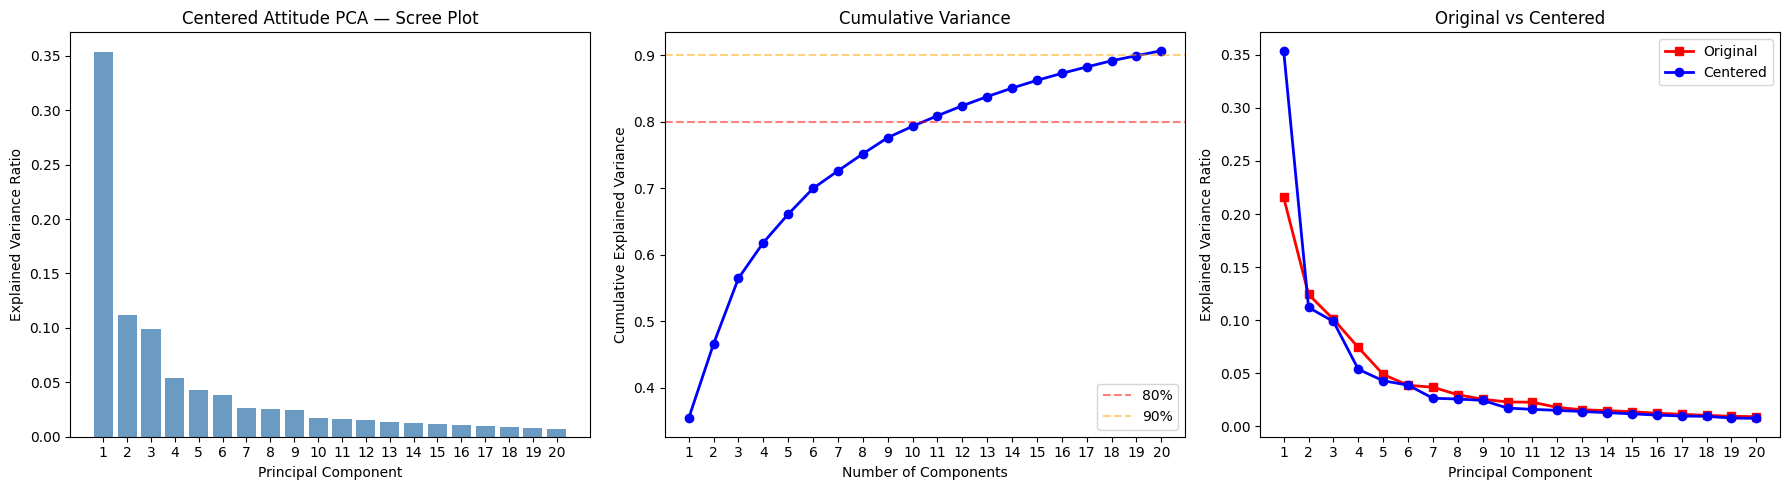

In [9]:
# Within-category centering: subtract category mean from each vector
X_centered = np.copy(X)
cat_means = {}

for cat in unique_cats:
    indices = [i for i, c in enumerate(categories) if c == cat]
    cat_mean = X[indices].mean(axis=0)
    cat_means[cat] = cat_mean
    X_centered[indices] -= cat_mean

# Verify centering
print('Within-category centering verification:')
for cat in unique_cats:
    indices = [i for i, c in enumerate(categories) if c == cat]
    mean_norm = np.linalg.norm(X_centered[indices].mean(axis=0))
    n = len(indices)
    print(f'  {cat:20s} ({n} positions): mean_norm = {mean_norm:.2e}')

# Centered PCA
pca_centered = PCA(n_components=n_components)
X_pca_centered = pca_centered.fit_transform(X_centered)

print(f'\nCentered PCA:')
print(f'  PC1 variance: {pca_centered.explained_variance_ratio_[0]:.2%}')
print(f'  Top 5 PCs: {[f"{v:.2%}" for v in pca_centered.explained_variance_ratio_[:5]]}')
print(f'  Cumulative (10 PCs): {sum(pca_centered.explained_variance_ratio_[:10]):.2%}')

# Side-by-side scree plot: original vs centered
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(range(1, 21), pca_centered.explained_variance_ratio_[:20],
            color='steelblue', alpha=0.8)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Centered Attitude PCA — Scree Plot')
axes[0].set_xticks(range(1, 21))

cum_var = np.cumsum(pca_centered.explained_variance_ratio_[:20])
axes[1].plot(range(1, 21), cum_var, 'bo-', linewidth=2, markersize=6)
axes[1].axhline(0.8, color='red', linestyle='--', alpha=0.5, label='80%')
axes[1].axhline(0.9, color='orange', linestyle='--', alpha=0.5, label='90%')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance')
axes[1].legend()
axes[1].set_xticks(range(1, 21))

axes[2].plot(range(1, 21), pca_orig.explained_variance_ratio_[:20],
             'rs-', label='Original', linewidth=2)
axes[2].plot(range(1, 21), pca_centered.explained_variance_ratio_[:20],
             'bo-', label='Centered', linewidth=2)
axes[2].set_xlabel('Principal Component')
axes[2].set_ylabel('Explained Variance Ratio')
axes[2].set_title('Original vs Centered')
axes[2].legend()
axes[2].set_xticks(range(1, 21))

plt.tight_layout()
plt.show()

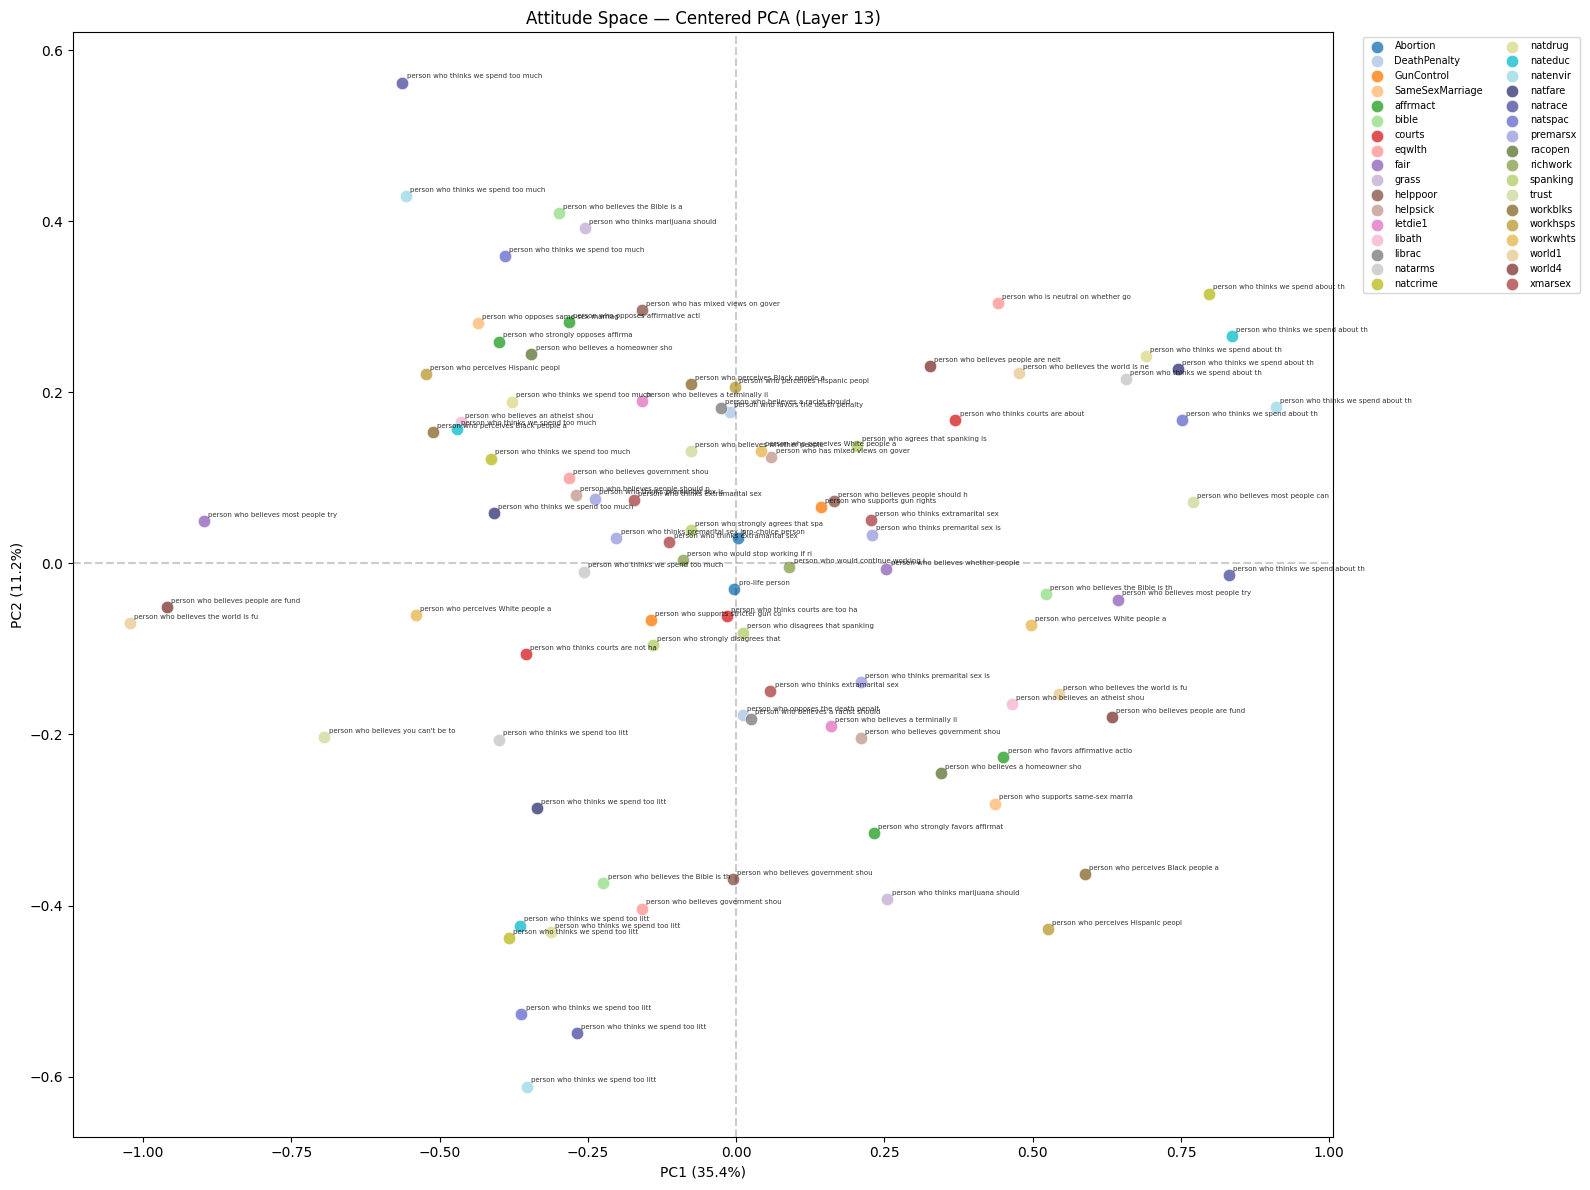

In [10]:
df_centered = pd.DataFrame({
    'PC1': X_pca_centered[:, 0],
    'PC2': X_pca_centered[:, 1],
    'PC3': X_pca_centered[:, 2],
    'label': labels,
    'category': categories,
    'short_label': [lab.split('_', 1)[1][:35] for lab in labels],
})

fig, ax = plt.subplots(figsize=(16, 12))

for cat in unique_cats:
    mask = df_centered['category'] == cat
    ax.scatter(
        df_centered.loc[mask, 'PC1'],
        df_centered.loc[mask, 'PC2'],
        label=cat, color=cat_to_color[cat],
        s=80, alpha=0.8, edgecolors='white', linewidth=0.5,
    )

for _, row in df_centered.iterrows():
    ax.annotate(
        row['short_label'], (row['PC1'], row['PC2']),
        fontsize=5, alpha=0.8, xytext=(3, 3), textcoords='offset points',
    )

ax.axhline(0, color='black', linestyle='--', alpha=0.2)
ax.axvline(0, color='black', linestyle='--', alpha=0.2)
ax.set_xlabel(f'PC1 ({pca_centered.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_centered.explained_variance_ratio_[1]:.1%})')
ax.set_title(f'Attitude Space — Centered PCA (Layer {REF_LAYER})')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=7, ncol=2)
plt.tight_layout()
plt.show()

In [11]:
print(f'{"=" * 80}')
print(f'CENTERED ATTITUDE PCA — PC POLES (Layer {REF_LAYER})')
print(f'{"=" * 80}')

for pc_idx in range(5):
    pc_name = f'PC{pc_idx + 1}'
    projections = X_pca_centered[:, pc_idx]
    sorted_idx = np.argsort(projections)
    var = pca_centered.explained_variance_ratio_[pc_idx]

    print(f'\n{pc_name} — Explained Variance: {var:.2%}')

    print(f'  POSITIVE pole (top 10):')
    for i in sorted_idx[-10:][::-1]:
        print(f'    {projections[i]:+8.4f}  [{categories[i]:20s}]  {labels[i]}')

    print(f'  NEGATIVE pole (bottom 10):')
    for i in sorted_idx[:10]:
        print(f'    {projections[i]:+8.4f}  [{categories[i]:20s}]  {labels[i]}')

CENTERED ATTITUDE PCA — PC POLES (Layer 13)

PC1 — Explained Variance: 35.39%
  POSITIVE pole (top 10):
     +0.9103  [natenvir            ]  natenvir_person who thinks we spend about the right amount on the environment
     +0.8354  [nateduc             ]  nateduc_person who thinks we spend about the right amount on education
     +0.8308  [natrace             ]  natrace_person who thinks we spend about the right amount on improving the conditions of Black Americans
     +0.7969  [natcrime            ]  natcrime_person who thinks we spend about the right amount on crime prevention
     +0.7708  [trust               ]  trust_person who believes most people can be trusted
     +0.7521  [natspac             ]  natspac_person who thinks we spend about the right amount on space exploration
     +0.7447  [natfare             ]  natfare_person who thinks we spend about the right amount on welfare
     +0.6904  [natdrug             ]  natdrug_person who thinks we spend about the right amount 

## Cross-Space Comparison: Attitude vs Demographic Vectors

Compare Attitude Space with the Demographic Space from Phase 5.1:
1. Cosine similarity heatmap between centered attitude and demographic vectors
2. Joint PCA combining both sets of vectors

Demographic vectors: 120 across 25 categories
Attitude vectors: 96 across 34 categories


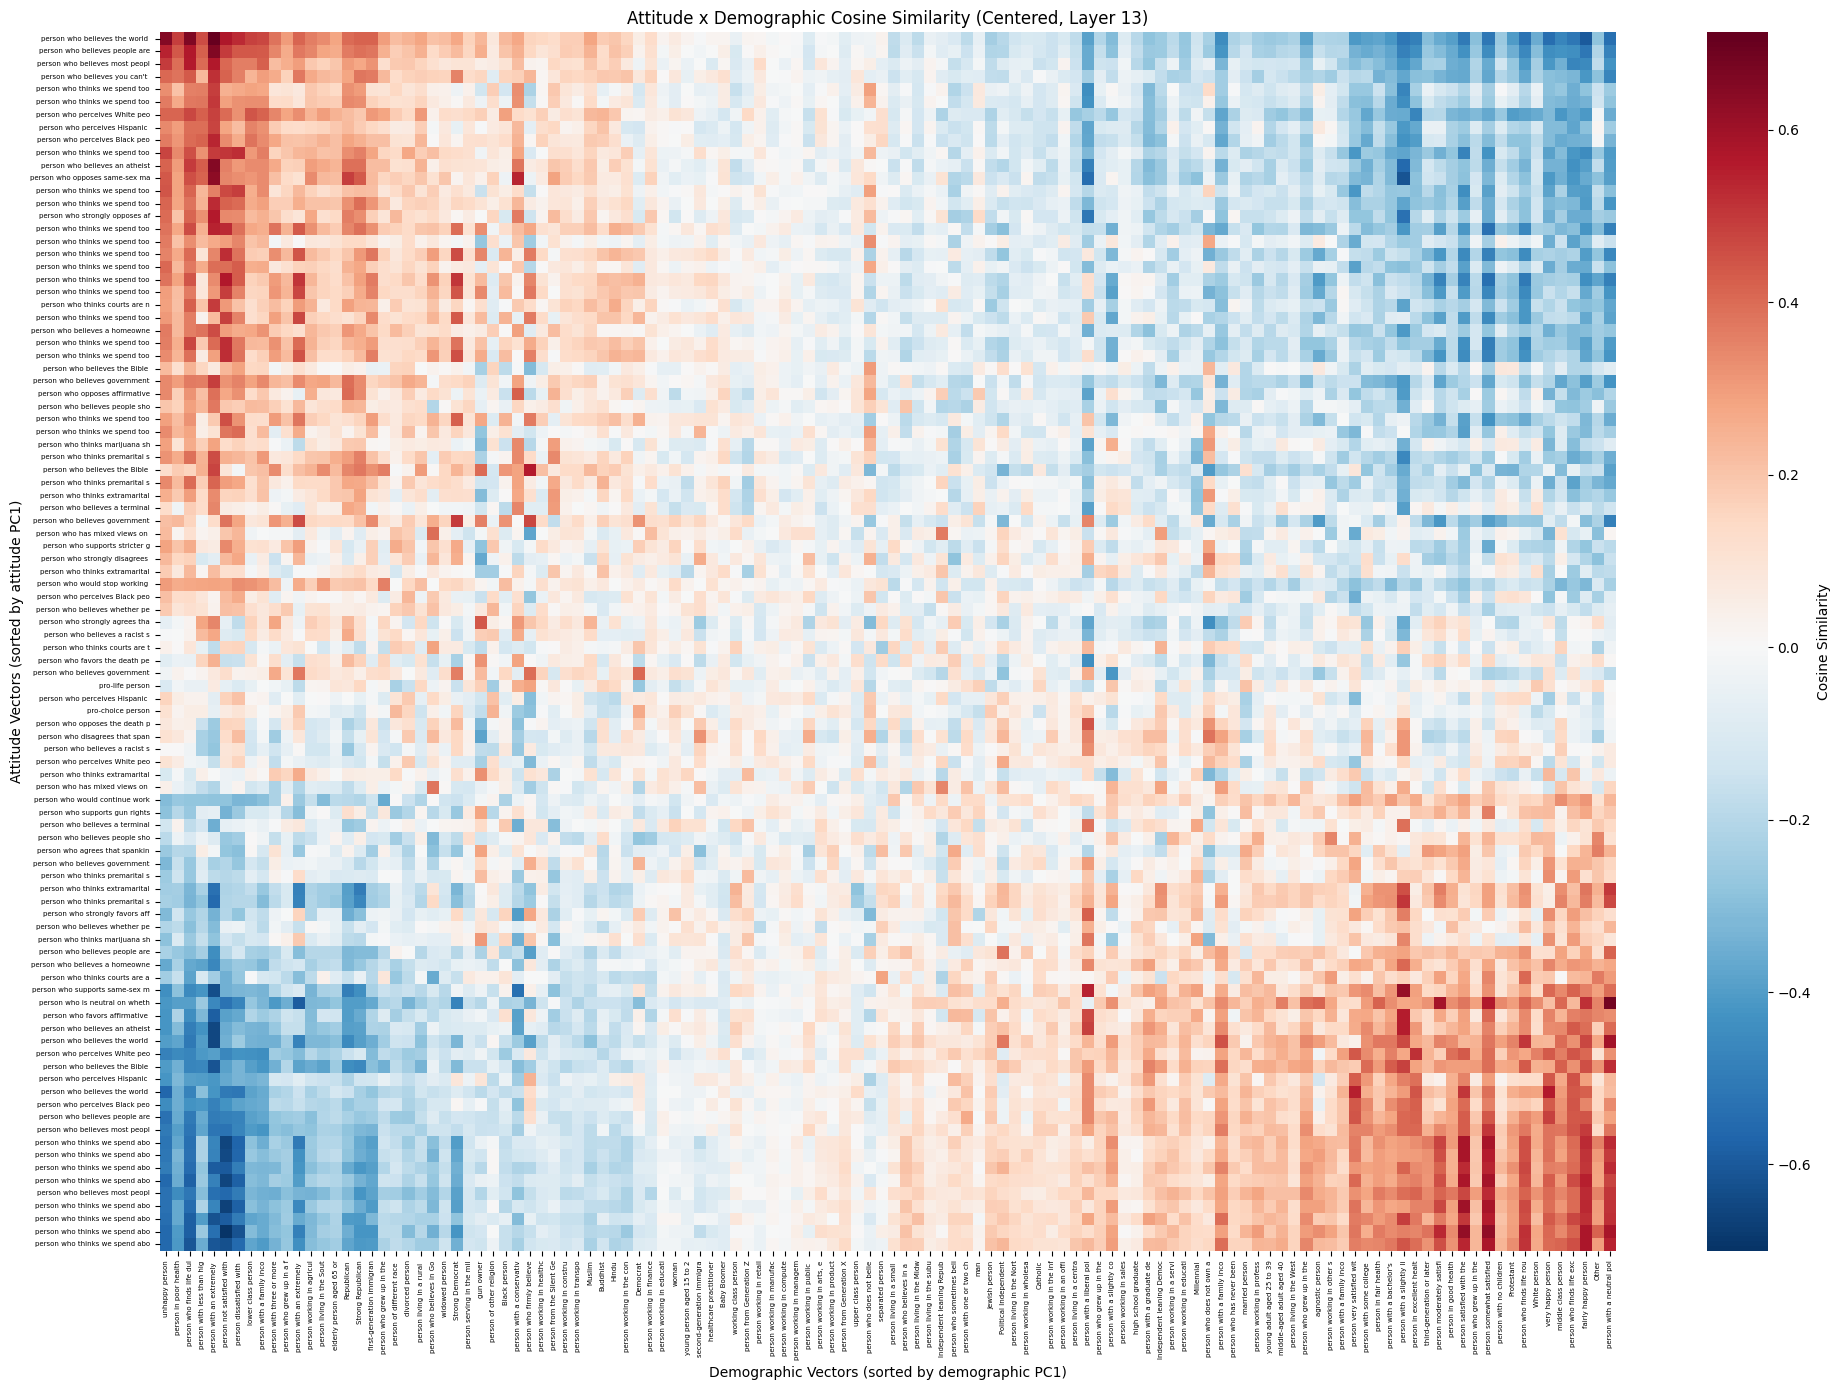

Cosine similarity matrix: (96, 120)
  Mean: -0.0005
  Std:  0.1908
  Range: [-0.6999, 0.7131]


In [12]:
# Load demographic vectors
demo_vectors = torch.load(
    os.path.join(VECTOR_DIR, f'gss_demographic_vectors_layer{REF_LAYER}.pt'),
    map_location='cpu',
    weights_only=True,
)

demo_labels = sorted(demo_vectors.keys())
demo_categories = [lab.split('_')[0] for lab in demo_labels]
demo_unique_cats = sorted(set(demo_categories))

# Build centered demographic matrix
X_demo = np.array([
    (demo_vectors[lab]['vector'] * demo_vectors[lab]['magnitude']).numpy()
    for lab in demo_labels
])

X_demo_centered = np.copy(X_demo)
for cat in demo_unique_cats:
    indices = [i for i, c in enumerate(demo_categories) if c == cat]
    cat_mean = X_demo[indices].mean(axis=0)
    X_demo_centered[indices] -= cat_mean

print(f'Demographic vectors: {len(demo_labels)} across {len(demo_unique_cats)} categories')
print(f'Attitude vectors: {len(labels)} across {len(unique_cats)} categories')

# Cosine similarity: centered attitudes x centered demographics
cos_sim = cosine_similarity(X_centered, X_demo_centered)

# Sort by attitude PC1 and demographic PC1
demo_pca = PCA(n_components=10)
X_demo_pca = demo_pca.fit_transform(X_demo_centered)

att_order = np.argsort(X_pca_centered[:, 0])
demo_order = np.argsort(X_demo_pca[:, 0])

att_short = [labels[i].split('_', 1)[1][:30] for i in att_order]
demo_short = [demo_labels[i].split('_', 1)[1][:25] for i in demo_order]

fig, ax = plt.subplots(figsize=(20, 14))
sns.heatmap(
    cos_sim[att_order][:, demo_order],
    xticklabels=demo_short,
    yticklabels=att_short,
    cmap='RdBu_r',
    center=0,
    ax=ax,
    cbar_kws={'label': 'Cosine Similarity'},
)
ax.set_xlabel('Demographic Vectors (sorted by demographic PC1)')
ax.set_ylabel('Attitude Vectors (sorted by attitude PC1)')
ax.set_title(f'Attitude x Demographic Cosine Similarity (Centered, Layer {REF_LAYER})')
plt.xticks(fontsize=5, rotation=90)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.show()

# Summary statistics
print(f'Cosine similarity matrix: {cos_sim.shape}')
print(f'  Mean: {cos_sim.mean():.4f}')
print(f'  Std:  {cos_sim.std():.4f}')
print(f'  Range: [{cos_sim.min():.4f}, {cos_sim.max():.4f}]')

Joint matrix: (216, 4096)
  Attitude vectors: 96
  Demographic vectors: 120
  Joint PC1 variance: 26.53%
  Top 5 PCs: ['26.53%', '7.32%', '6.68%', '4.84%', '3.79%']


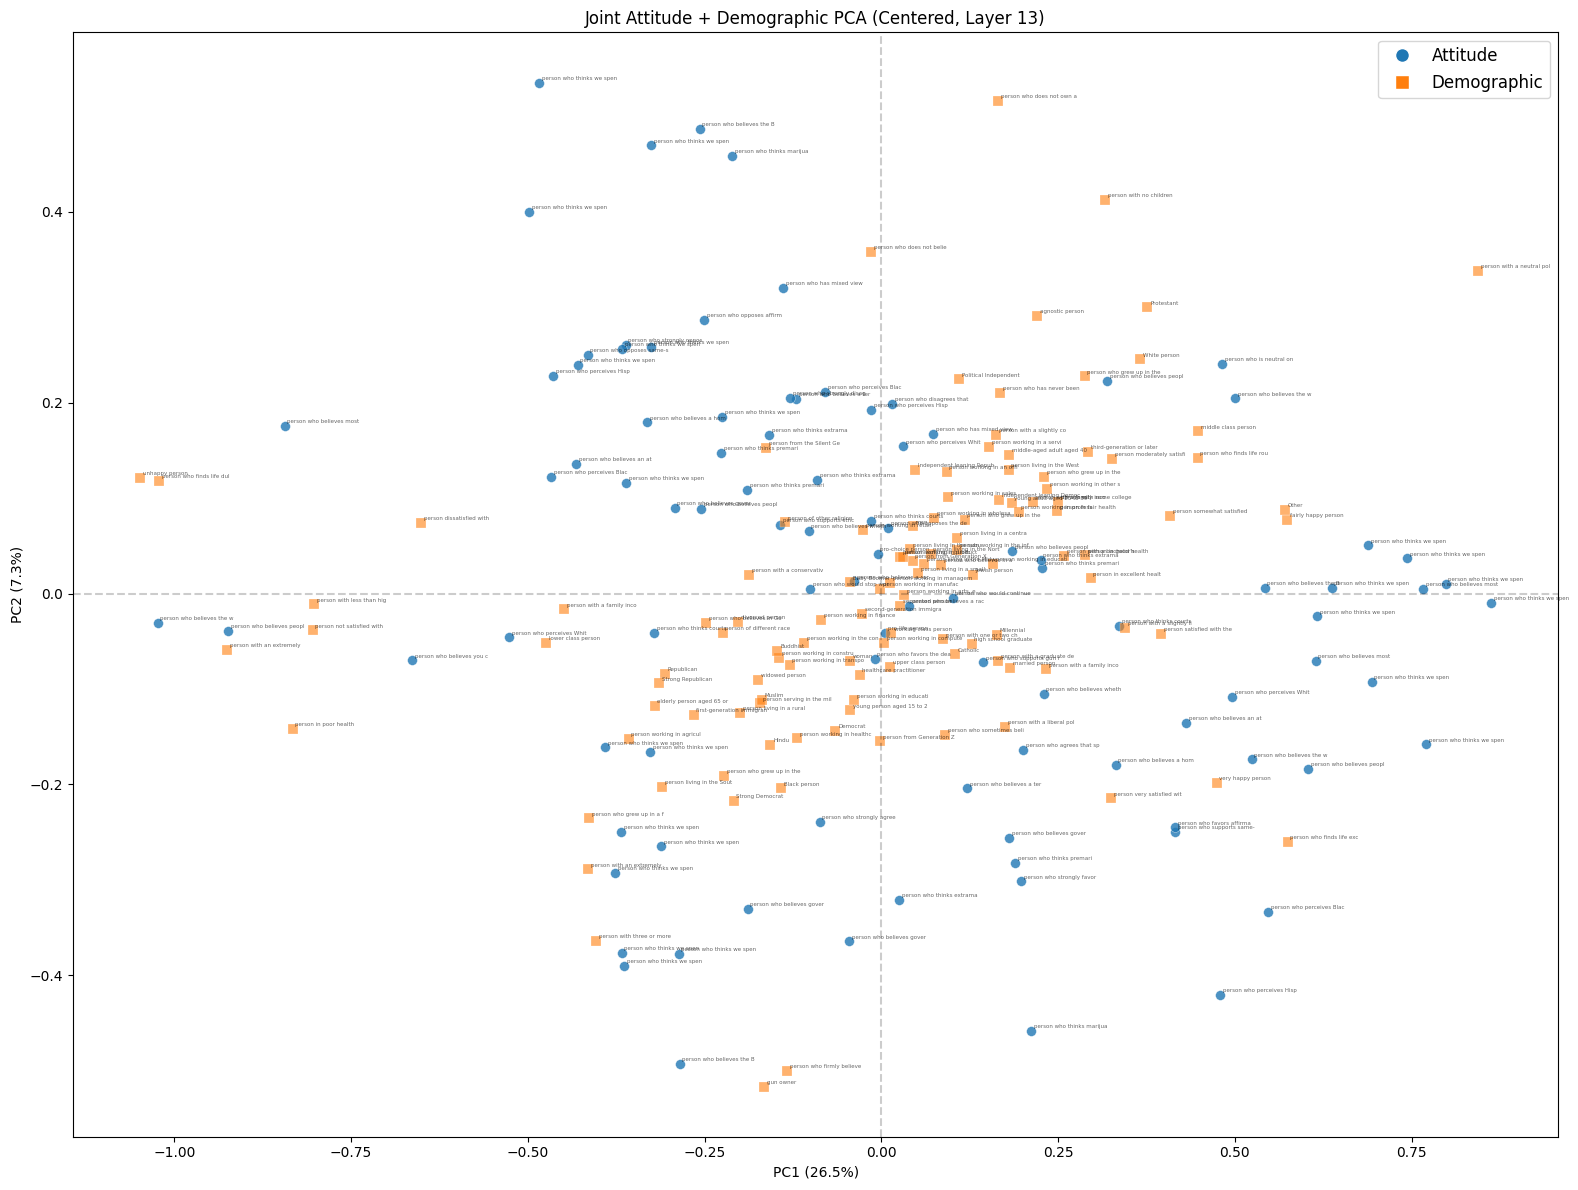

In [13]:
from matplotlib.lines import Line2D

# Stack centered attitude + centered demographic vectors
X_joint = np.vstack([X_centered, X_demo_centered])
joint_labels = labels + demo_labels
joint_categories = categories + demo_categories
joint_types = ['Attitude'] * len(labels) + ['Demographic'] * len(demo_labels)

# Joint PCA
pca_joint = PCA(n_components=min(30, len(joint_labels)))
X_joint_pca = pca_joint.fit_transform(X_joint)

print(f'Joint matrix: {X_joint.shape}')
print(f'  Attitude vectors: {len(labels)}')
print(f'  Demographic vectors: {len(demo_labels)}')
print(f'  Joint PC1 variance: {pca_joint.explained_variance_ratio_[0]:.2%}')
print(f'  Top 5 PCs: {[f"{v:.2%}" for v in pca_joint.explained_variance_ratio_[:5]]}')

# Scatter: color by type
fig, ax = plt.subplots(figsize=(16, 12))

for i in range(len(joint_labels)):
    if joint_types[i] == 'Attitude':
        color, marker, alpha = 'tab:blue', 'o', 0.8
    else:
        color, marker, alpha = 'tab:orange', 's', 0.6
    ax.scatter(
        X_joint_pca[i, 0], X_joint_pca[i, 1],
        color=color, marker=marker, s=50, alpha=alpha,
        edgecolors='white', linewidth=0.3,
    )

# Annotate all points
for i in range(len(joint_labels)):
    short = joint_labels[i].split('_', 1)[1][:25]
    ax.annotate(
        short, (X_joint_pca[i, 0], X_joint_pca[i, 1]),
        fontsize=4, alpha=0.6, xytext=(2, 2), textcoords='offset points',
    )

ax.axhline(0, color='black', linestyle='--', alpha=0.2)
ax.axvline(0, color='black', linestyle='--', alpha=0.2)
ax.set_xlabel(f'PC1 ({pca_joint.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca_joint.explained_variance_ratio_[1]:.1%})')
ax.set_title(f'Joint Attitude + Demographic PCA (Centered, Layer {REF_LAYER})')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue',
           markersize=10, label='Attitude'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='tab:orange',
           markersize=10, label='Demographic'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

Layer  5: PC1=16.37%, PC2=12.58%, PC3=10.89%
Layer  9: PC1=33.50%, PC2=10.58%, PC3=6.50%
Layer 13: PC1=35.39%, PC2=11.19%, PC3=9.87%
Layer 17: PC1=40.29%, PC2=13.50%, PC3=6.95%
Layer 20: PC1=43.42%, PC2=13.13%, PC3=7.23%


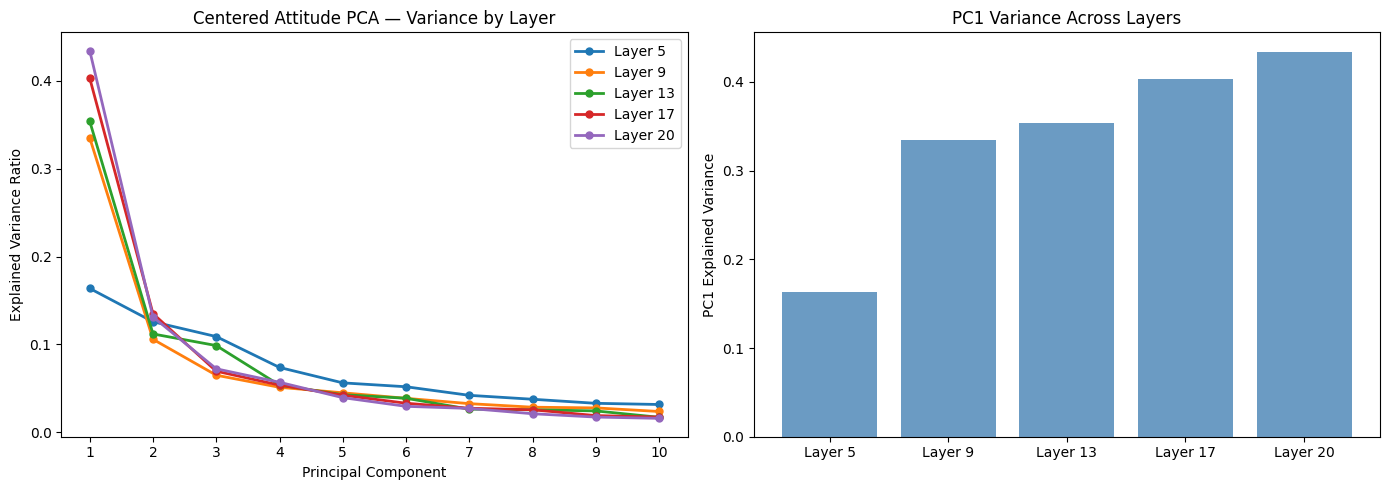


PC1 POLES ACROSS LAYERS

Layer 5 (PC1 = 16.37%):
  + pole: person who believes you can't , person who believes people are, person who perceives Hispanic , person who believes the world , person who perceives Black peo
  - pole: person who thinks we spend abo, person who thinks we spend abo, person who thinks we spend abo, person who thinks we spend abo, person who thinks we spend abo

Layer 9 (PC1 = 33.50%):
  + pole: person who thinks we spend abo, person who thinks we spend abo, person who thinks we spend abo, person who believes people are, person who thinks we spend abo
  - pole: person who believes people are, person who believes the world , person who perceives Black peo, person who perceives White peo, person who perceives Hispanic 

Layer 13 (PC1 = 35.39%):
  + pole: person who thinks we spend abo, person who thinks we spend abo, person who thinks we spend abo, person who thinks we spend abo, person who believes most peopl
  - pole: person who believes the world , person who b

In [14]:
comparison_layers = [5, 9, 13, 17, 20]
layer_results = {}

for layer in comparison_layers:
    vecs = torch.load(
        os.path.join(VECTOR_DIR, f'gss_attitude_vectors_layer{layer}.pt'),
        map_location='cpu',
        weights_only=True,
    )

    layer_labels = sorted(vecs.keys())
    layer_cats = [lab.split('_')[0] for lab in layer_labels]
    layer_unique_cats = sorted(set(layer_cats))

    layer_X = np.array([
        (vecs[lab]['vector'] * vecs[lab]['magnitude']).numpy()
        for lab in layer_labels
    ])

    # Within-category centering
    layer_X_c = np.copy(layer_X)
    for cat in layer_unique_cats:
        indices = [i for i, c in enumerate(layer_cats) if c == cat]
        cat_mean = layer_X[indices].mean(axis=0)
        layer_X_c[indices] -= cat_mean

    pca_c = PCA(n_components=min(20, len(layer_labels)))
    X_pca_c = pca_c.fit_transform(layer_X_c)

    layer_results[layer] = {
        'labels': layer_labels,
        'categories': layer_cats,
        'X_pca': X_pca_c,
        'pca': pca_c,
        'explained_variance': pca_c.explained_variance_ratio_,
    }

    print(f'Layer {layer:2d}: PC1={pca_c.explained_variance_ratio_[0]:.2%}, '
          f'PC2={pca_c.explained_variance_ratio_[1]:.2%}, '
          f'PC3={pca_c.explained_variance_ratio_[2]:.2%}')

# Variance comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for layer in comparison_layers:
    res = layer_results[layer]
    axes[0].plot(
        range(1, 11), res['explained_variance'][:10],
        'o-', label=f'Layer {layer}', linewidth=2, markersize=5,
    )
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Centered Attitude PCA — Variance by Layer')
axes[0].legend()
axes[0].set_xticks(range(1, 11))

# PC1 variance across layers
pc1_vars = [layer_results[l]['explained_variance'][0] for l in comparison_layers]
axes[1].bar(range(len(comparison_layers)), pc1_vars, color='steelblue', alpha=0.8)
axes[1].set_xticks(range(len(comparison_layers)))
axes[1].set_xticklabels([f'Layer {l}' for l in comparison_layers])
axes[1].set_ylabel('PC1 Explained Variance')
axes[1].set_title('PC1 Variance Across Layers')

plt.tight_layout()
plt.show()

# PC1 pole stability across layers
print(f'\n{"=" * 60}')
print('PC1 POLES ACROSS LAYERS')
print(f'{"=" * 60}')

for layer in comparison_layers:
    res = layer_results[layer]
    projections = res['X_pca'][:, 0]
    sorted_idx = np.argsort(projections)

    print(f'\nLayer {layer} (PC1 = {res["explained_variance"][0]:.2%}):')
    top5 = ', '.join(
        res['labels'][i].split('_', 1)[1][:30] for i in sorted_idx[-5:][::-1]
    )
    bot5 = ', '.join(
        res['labels'][i].split('_', 1)[1][:30] for i in sorted_idx[:5]
    )
    print(f'  + pole: {top5}')
    print(f'  - pole: {bot5}')

## Summary & Interpretation

### Attitude Space
- **~96 attitude positions** across **34 GSS social-issue variables** extracted from Llama-3 layers 5-20
- Shared baseline optimization: all positions use the same "person" baseline, computed once per layer
- Within-category centering removes the shared "attitude-ness" direction per variable

### Key Questions
1. **Is attitude PC1 a liberal-conservative axis?** Since attitudes are inherently political (unlike demographics), we expect a clearer partisan structure in attitude PC1.
2. **Do attitude and demographic vectors intermingle in joint PCA?** If they share the same representational space, the model encodes attitudes and demographics along similar directions.
3. **Which layer shows the strongest attitude structure?** Compare with demographic results from Phase 5.1.

### Next Steps
- Project demographic vectors onto attitude PCs (and vice versa) for cross-space alignment
- Use attitude vectors for steering experiments on policy questions
- Combine attitude + demographic vectors for composite persona steering